In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

#color
from colorama import Fore, Back, Style
import os

import matplotlib.pyplot as plt
#pydicom
import pydicom

#plotly
# !pip install chart_studio
# !pip install cufflinks
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [3]:
path = Path('/kaggle/osic_pulmonary')
assert path.exists()

In [4]:
!ls {path}

sample_submission.csv  test  test.csv  train  train.csv


In [5]:
!ls {path}/'train'

ID00007637202177411956430  ID00131637202220424084844  ID00285637202278913507108
ID00009637202177434476278  ID00132637202222178761324  ID00288637202279148973731
ID00010637202177584971671  ID00133637202223847701934  ID00290637202279304677843
ID00011637202177653955184  ID00134637202223873059688  ID00291637202279398396106
ID00012637202177665765362  ID00135637202224630271439  ID00294637202279614924243
ID00014637202177757139317  ID00136637202224951350618  ID00296637202279895784347
ID00015637202177877247924  ID00138637202231603868088  ID00298637202280361773446
ID00019637202178323708467  ID00139637202231703564336  ID00299637202280383305867
ID00020637202178344345685  ID00140637202231728595149  ID00305637202281772703145
ID00023637202179104603099  ID00149637202232704462834  ID00307637202282126172865
ID00025637202179541264076  ID00161637202235731948764  ID00309637202282195513787
ID00026637202179561894768  ID00165637202237320314458  ID00312637202282607344793
ID00027637202179689871102  ID00167637202

In [6]:
!ls {path}/'train/ID00007637202177411956430' | sort -n

1.dcm
2.dcm
3.dcm
4.dcm
5.dcm
6.dcm
7.dcm
8.dcm
9.dcm
10.dcm
11.dcm
12.dcm
13.dcm
14.dcm
15.dcm
16.dcm
17.dcm
18.dcm
19.dcm
20.dcm
21.dcm
22.dcm
23.dcm
24.dcm
25.dcm
26.dcm
27.dcm
28.dcm
29.dcm
30.dcm


In [7]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        5 non-null      object 
 1   Weeks          5 non-null      int64  
 2   FVC            5 non-null      int64  
 3   Percent        5 non-null      float64
 4   Age            5 non-null      int64  
 5   Sex            5 non-null      object 
 6   SmokingStatus  5 non-null      object 
dtypes: float64(1), int64(3), object(3)
memory usage: 408.0+ bytes


In [10]:
train_df[train_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445106,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678814,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632983,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610393,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935763,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911221,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377336,73,Male,Ex-smoker


In [11]:
test_df[test_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker


In [12]:
train_df.groupby(['SmokingStatus'])['Patient'].count()

SmokingStatus
Currently smokes      82
Ex-smoker           1038
Never smoked         429
Name: Patient, dtype: int64

In [13]:
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{train_df['Patient'].count()},", Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{train_df['Patient'].value_counts().shape[0]}.")

The total patient ids are  1549, from those the unique ids are  176.


In [14]:
train_patient_ids = set(train_df['Patient'].unique())
test_patient_ids = set(test_df['Patient'].unique())

train_patient_ids.intersection(test_patient_ids)

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

In [15]:
train_df['Weeks'].unique()

array([ -4,   5,   7,   9,  11,  17,  29,  41,  57,   8,  13,  15,  22,
        33,  45,  60,   0,   1,   3,  25,  37,  54,   6,  19,  32,  43,
        58,  35,  39,  47,  71,  87,   2,   4,  14,  26,  12,  21,  31,
        40,  52,  69,  16,  18,  20,  38,  53,  66,  23,  44,  70,  -3,
        27,  55,  49,  51,  81,  98,  30,  34,  36,  42,  65,  59,  24,
        63,  10,  61,  -1,  48,  56,  75,  28,  76,  46,  50,  83,  62,
        79,  -5,  73, 102,  82,  97, 100,  67,  91, 107,  85,  72,  84,
        78,  64,  68,  89, 101, 116,  -2,  74,  92, 104, 117, 133,  96,
        77,  94,  86,  88,  95,  93,  80,  99])

In [16]:
len(train_df['Weeks'].unique())

112

In [17]:
np.sort(train_df['Weeks'].unique())

array([ -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 104, 107, 116, 117, 133])

### Patient and weeks

In [18]:
train_df.groupby(['Patient'])['Weeks'].agg(['count', 'min', 'max'])

,count,min,max
Patient,,,
ID00007637202177411956430,9,-4,57
ID00009637202177434476278,9,8,60
ID00010637202177584971671,9,0,54
ID00011637202177653955184,9,6,58
ID00012637202177665765362,9,33,87
...,...,...,...
ID00419637202311204720264,9,6,59
ID00421637202311550012437,10,15,70
ID00422637202311677017371,8,6,47


In [19]:
train_df[train_df['Patient'] == 'ID00007637202177411956430']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker
5,ID00007637202177411956430,17,2101,52.868646,79,Male,Ex-smoker
6,ID00007637202177411956430,29,2000,50.327126,79,Male,Ex-smoker
7,ID00007637202177411956430,41,2064,51.937594,79,Male,Ex-smoker
8,ID00007637202177411956430,57,2057,51.761449,79,Male,Ex-smoker


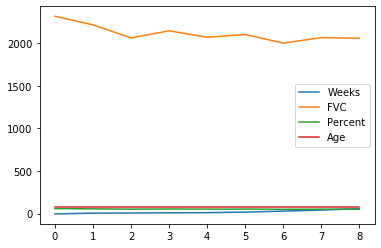

In [20]:
train_df[train_df['Patient'] == 'ID00007637202177411956430'].plot()

In [21]:
train_df['Patient'].value_counts()

ID00388637202301028491611    10
ID00421637202311550012437    10
ID00167637202237397919352    10
ID00099637202206203080121    10
ID00229637202260254240583    10
                             ..
ID00111637202210956877205     7
ID00128637202219474716089     7
ID00052637202186188008618     7
ID00047637202184938901501     6
ID00267637202270790561585     6
Name: Patient, Length: 176, dtype: int64

In [22]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [23]:
train_df[train_df['Patient'] == 'ID00419637202311204720264']

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
1504,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1505,ID00419637202311204720264,7,2859,66.445106,73,Male,Ex-smoker
1506,ID00419637202311204720264,9,2783,64.678814,73,Male,Ex-smoker
1507,ID00419637202311204720264,10,2719,63.191410,73,Male,Ex-smoker
1508,ID00419637202311204720264,13,2738,63.632983,73,Male,Ex-smoker
1509,ID00419637202311204720264,18,2694,62.610393,73,Male,Ex-smoker
1510,ID00419637202311204720264,31,2708,62.935763,73,Male,Ex-smoker
1511,ID00419637202311204720264,43,2793,64.911221,73,Male,Ex-smoker
1512,ID00419637202311204720264,59,2727,63.377336,73,Male,Ex-smoker


### Number of Patients and Images in Training Images Folder

In [24]:
def count_files(folder):
    files = folders = 0

    train_path = path/folder

    for _, dirnames, filenames in os.walk(train_path):
      # ^ this idiom means "we won't be using this value"
        files += len(filenames)
        folders += len(dirnames)
    #print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
    print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files/images, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'folders/patients')

In [25]:
count_files('train')

33,026  files/images, 176  folders/patients


In [26]:
train_path = path/'train'

In [27]:
files = []
patient_lenfiles = {}
for directory, dirnames, filenames in os.walk(train_path):
    patient_id = re.sub(r'.+/(.+)', r'\1', directory)
    files.append(len(filenames))
    if(patient_id.find('ID') == 0):
        patient_lenfiles[patient_id] = len(filenames)

print(Fore.YELLOW +f'{round(np.mean(files)):,}',Style.RESET_ALL,'average files/images per patient')
print(Fore.BLUE +f'{round(np.max(files)):,}',Style.RESET_ALL, 'max files/images per patient')
print(Fore.GREEN +f'{round(np.min(files)):,}',Style.RESET_ALL,'min files/images per patient')

187.0  average files/images per patient
1,018  max files/images per patient
0  min files/images per patient


In [28]:
img_lengths = [v for k, v in patient_lenfiles.items()]
img_lengths.sort()
img_lengths[:10]
img_lengths[-10:]

[493, 497, 498, 512, 521, 574, 577, 602, 825, 1018]

In [29]:
!ls {train_path/'ID00007637202177411956430'}

10.dcm	13.dcm	16.dcm	19.dcm	21.dcm	24.dcm	27.dcm	2.dcm	4.dcm  7.dcm
11.dcm	14.dcm	17.dcm	1.dcm	22.dcm	25.dcm	28.dcm	30.dcm	5.dcm  8.dcm
12.dcm	15.dcm	18.dcm	20.dcm	23.dcm	26.dcm	29.dcm	3.dcm	6.dcm  9.dcm


### Submission file

In [30]:
submission_df = pd.read_csv(path/'sample_submission.csv')

In [31]:
submission_df.columns

Index(['Patient_Week', 'FVC', 'Confidence'], dtype='object')

In [32]:
submission_df.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
1,ID00421637202311550012437_-12,2000,100
2,ID00422637202311677017371_-12,2000,100
3,ID00423637202312137826377_-12,2000,100
4,ID00426637202313170790466_-12,2000,100


In [33]:
import re
from collections import Counter

patients = [re.sub(r'([^_]+).+', r'\1', r) for r in submission_df['Patient_Week']]
Counter(patients)

Counter({'ID00419637202311204720264': 146,
         'ID00421637202311550012437': 146,
         'ID00422637202311677017371': 146,
         'ID00423637202312137826377': 146,
         'ID00426637202313170790466': 146})

In [34]:
weeks = [re.sub(r'[^_]+_(.+)', r'\1', r) for r in submission_df['Patient_Week']]

In [35]:
Counter(weeks)

Counter({'-12': 5,
         '-11': 5,
         '-10': 5,
         '-9': 5,
         '-8': 5,
         '-7': 5,
         '-6': 5,
         '-5': 5,
         '-4': 5,
         '-3': 5,
         '-2': 5,
         '-1': 5,
         '0': 5,
         '1': 5,
         '2': 5,
         '3': 5,
         '4': 5,
         '5': 5,
         '6': 5,
         '7': 5,
         '8': 5,
         '9': 5,
         '10': 5,
         '11': 5,
         '12': 5,
         '13': 5,
         '14': 5,
         '15': 5,
         '16': 5,
         '17': 5,
         '18': 5,
         '19': 5,
         '20': 5,
         '21': 5,
         '22': 5,
         '23': 5,
         '24': 5,
         '25': 5,
         '26': 5,
         '27': 5,
         '28': 5,
         '29': 5,
         '30': 5,
         '31': 5,
         '32': 5,
         '33': 5,
         '34': 5,
         '35': 5,
         '36': 5,
         '37': 5,
         '38': 5,
         '39': 5,
         '40': 5,
         '41': 5,
         '42': 5,
         '43': 5,

In [36]:
submission_df[submission_df['Patient_Week'].str.contains('ID00419637202311204720264')]

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,2000,100
5,ID00419637202311204720264_-11,2000,100
10,ID00419637202311204720264_-10,2000,100
15,ID00419637202311204720264_-9,2000,100
20,ID00419637202311204720264_-8,2000,100
...,...,...,...
705,ID00419637202311204720264_129,2000,100
710,ID00419637202311204720264_130,2000,100
715,ID00419637202311204720264_131,2000,100
720,ID00419637202311204720264_132,2000,100


In [37]:
test_df

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00419637202311204720264,6,3020,70.186855,73,Male,Ex-smoker
1,ID00421637202311550012437,15,2739,82.045291,68,Male,Ex-smoker
2,ID00422637202311677017371,6,1930,76.672493,73,Male,Ex-smoker
3,ID00423637202312137826377,17,3294,79.258903,72,Male,Ex-smoker
4,ID00426637202313170790466,0,2925,71.824968,73,Male,Never smoked


In [38]:
count_files('test')

1,261  files/images, 5  folders/patients


### Weeks Distribution

In [39]:
train_df['Weeks'].value_counts()

 8     45
 12    44
 18    42
 10    41
 6     40
       ..
 95     1
 93     1
 91     1
 88     1
-2      1
Name: Weeks, Length: 112, dtype: int64

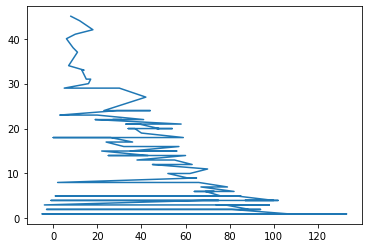

In [40]:
train_df['Weeks'].value_counts().plot()

### Visualize images

In [41]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array, cmap='gray') # cmap=plt.cm.bone)
    plt.show()

In [46]:
ds = pydicom.dcmread(path/"train/ID00007637202177411956430/1.dcm")
print(type(ds))
dir(ds)

<class 'pydicom.dataset.FileDataset'>


'FFS'

In [48]:
??plt.imshow

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    shape=<deprecated parameter>,
    filternorm=1,
    filterrad=4.0,
    imlim=<deprecated parameter>,
    resample=None,
    url=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Display an image, i.e. data on a 2D regular raster.

Parameters
----------
X : array-like or PIL image
    The image data. Supported array shapes are:

    - (M, N): an image with scalar data. The data is visualized
      using a colormap.
    - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
    - (M, N, 4): an image with RGBA values (0-1 float or 0-255 int),
      i.e. including transparency.

    The first two dimensions (M, N) define the rows and columns of
    the image.

    Out-of-range RGB(A) values are clipped.

cmap : str or `~matplotlib.colors.Colormap`, optional
    The Colormap instance or register

total images for patient ID00007637202177411956430:  30
/kaggle/osic_pulmonary/train/ID00007637202177411956430/1.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/2.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/3.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/4.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/5.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/6.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/7.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/8.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/9.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/10.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/11.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/12.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/13.dcm FFS
/kaggle/osic_pulmonary/train/ID00007637202177411956430/14.dcm FFS
/kaggle/osic_pulmonary/train/

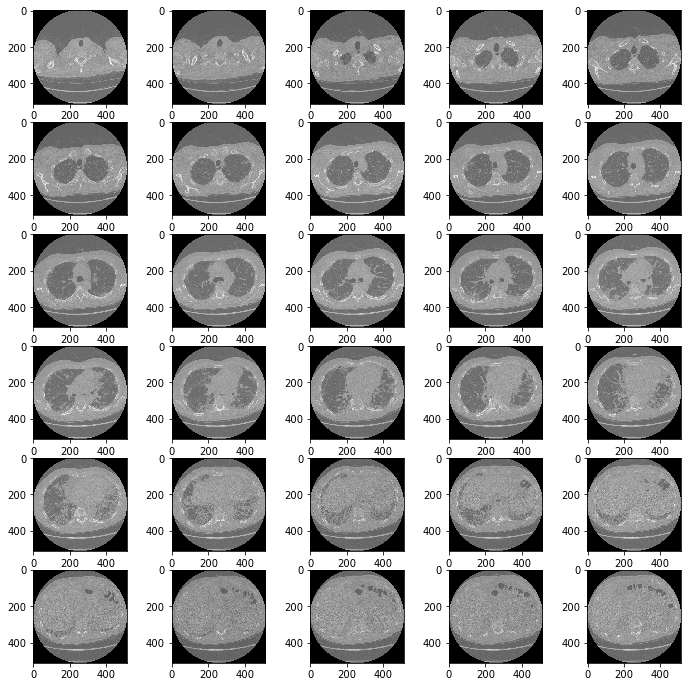

In [47]:
imdir = path/"train/ID00007637202177411956430"
print("total images for patient ID00007637202177411956430: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 5
rows = 6
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = str(imdir) + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    print(filename, ds.PatientPosition)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

In [48]:
train_df.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])

In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1535 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1535 non-null   object 
 1   Weeks          1535 non-null   int64  
 2   FVC            1535 non-null   int64  
 3   Percent        1535 non-null   float64
 4   Age            1535 non-null   int64  
 5   Sex            1535 non-null   object 
 6   SmokingStatus  1535 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 95.9+ KB
